In [50]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, f1_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.width', 1000) 
pd.set_option('display.max_colwidth', None)

In [62]:
script_dir = Path.cwd()

baseTablePath = script_dir.parent.parent/"data"/"analysis_base_clean.csv"
df = pd.read_csv(baseTablePath)

# df.dropna(inplace = True)

In [63]:
df.head()

,seqn,age_years,age_group,sex,race_eth,educ_level,pir,mcq220,ever_cancer,dpq_total,dpq_cat,smoke_status,hscrp_mg_l_raw,hscrp_cat,bmx_bmi,bmx_weight_kg,bmx_height_cm,bmx_waist_cm,bmx_hip_cm,dpq_severity,hscrp_flag_acute
0,130379,66.0,60+,1,3.0,5.0,5.00,1,1,1.0,none-minimal,former,2.03,average,33.5,101.8,174.2,114.7,112.4,None-minimal,0
1,130380,44.0,40-49,2,2.0,3.0,1.41,2,0,2.0,none-minimal,never,5.62,high,29.7,69.4,152.9,93.5,98.0,None-minimal,0
2,130386,34.0,30-39,1,1.0,4.0,1.33,2,0,1.0,none-minimal,former,1.05,average,30.2,90.6,173.3,106.1,110.6,None-minimal,0
3,130388,27.0,18-29,2,4.0,4.0,0.81,2,0,NaN,NaN,current,NaN,NaN,43.7,123.7,168.2,118.5,134.0,NaN,0
4,130390,31.0,30-39,2,3.0,3.0,2.16,2,0,NaN,NaN,never,11.20,high,46.0,122.7,163.3,131.0,138.5,NaN,1


In [64]:
for i in df.columns:
    cnt = df[i].isna().sum()
    pct = df[i].isna().mean()*100
    print(f"{i}: {cnt} missing ({pct:.2f}%)")

seqn: 0 missing (0.00%)
age_years: 84 missing (1.08%)
age_group: 0 missing (0.00%)
sex: 0 missing (0.00%)
race_eth: 934 missing (11.97%)
educ_level: 24 missing (0.31%)
pir: 1384 missing (17.74%)
mcq220: 0 missing (0.00%)
ever_cancer: 0 missing (0.00%)
dpq_total: 4200 missing (53.85%)
dpq_cat: 2596 missing (33.28%)
smoke_status: 27 missing (0.35%)
hscrp_mg_l_raw: 2213 missing (28.37%)
hscrp_cat: 2212 missing (28.36%)
bmx_bmi: 1836 missing (23.54%)
bmx_weight_kg: 1837 missing (23.55%)
bmx_height_cm: 1809 missing (23.19%)
bmx_waist_cm: 2079 missing (26.65%)
bmx_hip_cm: 2134 missing (27.36%)
dpq_severity: 4200 missing (53.85%)
hscrp_flag_acute: 0 missing (0.00%)


In [65]:
df.loc[df['dpq_total'].isna() & df['dpq_cat'].notna(), 'dpq_cat'] = np.nan

In [66]:
df.loc[df['hscrp_mg_l_raw'].isna() & df['hscrp_cat'].notna(), 'hscrp_cat'] = np.nan

In [67]:
df['early_onset_proxy'] = df['age_years'].apply(lambda x: 1 if x <=50 else 0)
df['stress_ranking'] = df['dpq_total'].apply(lambda x: np.nan if pd.isna(x) else (1 if x >= 15 else 0))
df.drop(columns=['bmx_weight_kg','bmx_height_cm','bmx_waist_cm','bmx_hip_cm','mcq220'], inplace = True)

In [68]:
for i in df.columns:
    cnt = df[i].isna().sum()
    pct = df[i].isna().mean()*100
    print(f"{i}: {cnt} missing ({pct:.2f}%)")

seqn: 0 missing (0.00%)
age_years: 84 missing (1.08%)
age_group: 0 missing (0.00%)
sex: 0 missing (0.00%)
race_eth: 934 missing (11.97%)
educ_level: 24 missing (0.31%)
pir: 1384 missing (17.74%)
ever_cancer: 0 missing (0.00%)
dpq_total: 4200 missing (53.85%)
dpq_cat: 4200 missing (53.85%)
smoke_status: 27 missing (0.35%)
hscrp_mg_l_raw: 2213 missing (28.37%)
hscrp_cat: 2213 missing (28.37%)
bmx_bmi: 1836 missing (23.54%)
dpq_severity: 4200 missing (53.85%)
hscrp_flag_acute: 0 missing (0.00%)
early_onset_proxy: 0 missing (0.00%)
stress_ranking: 4200 missing (53.85%)


In [69]:
df[['pir','age_years','dpq_total','hscrp_mg_l_raw','bmx_bmi']].corr()

,pir,age_years,dpq_total,hscrp_mg_l_raw,bmx_bmi
pir,1.000000,0.054723,-0.243467,-0.105345,-0.079053
age_years,0.054723,1.000000,-0.131344,-0.016666,-0.003336
dpq_total,-0.243467,-0.131344,1.000000,0.097424,0.087248
hscrp_mg_l_raw,-0.105345,-0.016666,0.097424,1.000000,0.287650
bmx_bmi,-0.079053,-0.003336,0.087248,0.287650,1.000000


In [70]:
vars_cont = ['age_years', 'pir', 'dpq_total', 'hscrp_mg_l_raw', 'bmx_bmi']
vars_cat  = [ 'smoke_status', 'educ_level']

In [71]:
# df_pca = df[df['ever_cancer']==1]

df_pca = df[vars_cont + vars_cat].copy()
df_pca.dropna(inplace=True)
df_pca = pd.get_dummies(df_pca, columns=vars_cat, drop_first=True)

In [72]:
scaled = StandardScaler().fit_transform(df_pca)

In [73]:
from sklearn.decomposition import PCA

pca = PCA()
components = pca.fit_transform(scaled)
explained = pca.explained_variance_ratio_

In [74]:
explained

array([0.20808326, 0.14901318, 0.12435315, 0.11250827, 0.10461682,
       0.0932065 , 0.0710201 , 0.05950132, 0.05088862, 0.02339223,
       0.00341654])

In [75]:
df_pca_final = pd.DataFrame(components, columns=[f'PC{i+1}' for i in range(components.shape[1])])
df_pca_final['ever_cancer'] = df['ever_cancer']

In [76]:

ttest_ind(
    df_pca_final[df_pca_final['ever_cancer']==1]['PC1'],
    df_pca_final[df_pca_final['ever_cancer']==0]['PC1'],
    nan_policy='omit'
)

TtestResult(statistic=np.float64(-0.8768098687338137), pvalue=np.float64(0.3806633281238747), df=np.float64(2869.0))

In [77]:

X = df_pca_final[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']]
y = df_pca_final['ever_cancer']

X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.414284
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            ever_cancer   No. Observations:                 2871
Model:                          Logit   Df Residuals:                     2863
Method:                           MLE   Df Model:                            7
Date:                Wed, 26 Nov 2025   Pseudo R-squ.:                0.004653
Time:                        12:40:53   Log-Likelihood:                -1189.4
converged:                       True   LL-Null:                       -1195.0
Covariance Type:            nonrobust   LLR p-value:                    0.1335
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7755      0.053    -33.270      0.000      -1.880      -1.671
PC1           -0.0272      0.

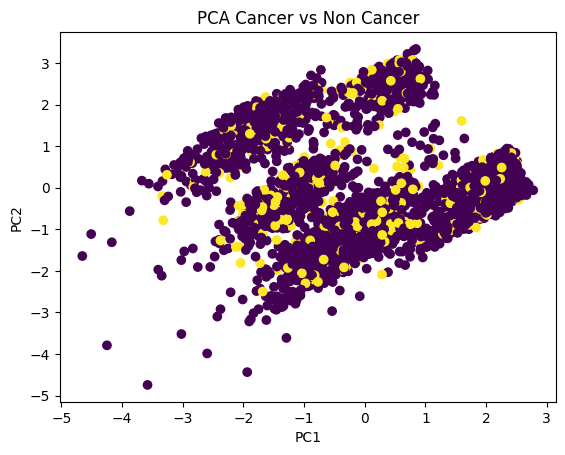

In [78]:
plt.scatter(df_pca_final['PC1'], df_pca_final['PC2'], c=df_pca_final['ever_cancer'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Cancer vs Non Cancer')
plt.show()

### Supervised Learning

In [79]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cont_vars = ['age_years', 'pir', 'dpq_total', 'hscrp_mg_l_raw', 'bmx_bmi']
cat_vars = ['sex', 'race_eth', 'educ_level', 'smoke_status']

X = df[cont_vars + cat_vars].copy()
y = df['ever_cancer']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_vars),
        ('num', StandardScaler(), cont_vars)
    ]
)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

brf_model = ImbPipeline(steps=[
    ('prep', preprocessor),
    ('brf', BalancedRandomForestClassifier(
        n_estimators=400,
        sampling_strategy='auto',
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42
    ))
])

In [81]:
brf_model.fit(X_train, y_train)
y_pred = brf_model.predict(X_test)
y_prob = brf_model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6574358974358975
F1 Score: 0.400359066427289
AUC: 0.7697206983161756

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.64      0.76      1658
           1       0.27      0.76      0.40       292

    accuracy                           0.66      1950
   macro avg       0.61      0.70      0.58      1950
weighted avg       0.84      0.66      0.71      1950



#### Feature Importance

In [82]:
ohe = brf_model.named_steps['prep'].transformers_[0][1]
ohe_features = list(ohe.get_feature_names_out(cat_vars))

all_features = ohe_features + cont_vars
brf = brf_model.named_steps['brf']
importances = brf.feature_importances_

feat_imp = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp)

                feature  importance
13            age_years    0.395607
14                  pir    0.129018
16       hscrp_mg_l_raw    0.124528
17              bmx_bmi    0.123095
15            dpq_total    0.061519
2          race_eth_3.0    0.033384
0                 sex_2    0.022472
10  smoke_status_former    0.021031
7        educ_level_4.0    0.015040
11   smoke_status_never    0.014310
6        educ_level_3.0    0.012578
8        educ_level_5.0    0.012494
4          race_eth_nan    0.009050
3          race_eth_4.0    0.008876
1          race_eth_2.0    0.008568
5        educ_level_2.0    0.007935
9        educ_level_nan    0.000312
12     smoke_status_nan    0.000181


### Split and Comparision

In [83]:
young_df = df[df['early_onset_proxy']==1]
old_df = df[df['early_onset_proxy']==0]

def make_group_xy(dataframe, target_col):
    cols = cont_vars + cat_vars + [target_col]
    sub = dataframe[cols].dropna().copy()
    X = sub[cont_vars + cat_vars]
    y = sub[target_col].astype(int)
    return X, y

X_young, y_young = make_group_xy(young_df, target_col='ever_cancer')
X_old,   y_old   = make_group_xy(old_df, target_col='ever_cancer')

print('Young X shape:', X_young.shape, '| ever_cancer rate:', y_young.mean().round(3))
print('Old   X shape:', X_old.shape,   '| ever_cancer rate:', y_old.mean().round(3))

Young X shape: (1050, 9) | ever_cancer rate: 0.03
Old   X shape: (1512, 9) | ever_cancer rate: 0.237


In [84]:
from sklearn.base import clone

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cont_vars),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_vars),
    ]
)

base_rf = BalancedRandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

def fit_and_eval_balanced_rf(X, y, group_name='group'):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    model = Pipeline([
        ('preprocess', preprocess),
        ('clf', clone(base_rf)),
    ])

    model.fit(X_train, y_train)

    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1  = f1_score(y_test, y_pred)
    cm  = confusion_matrix(y_test, y_pred)

    print(f'\n=== {group_name} Balanced RF ===')
    print('AUC:', round(auc, 3))
    print('F1 :', round(f1, 3))
    print('Confusion matrix:\n', cm)
    print('\nClassification report:\n', classification_report(y_test, y_pred))

    return model, {'AUC': auc, 'F1': f1, 'cm': cm, 'y_test': y_test, 'y_pred': y_pred}

model_young, metrics_young = fit_and_eval_balanced_rf(X_young, y_young, group_name='Young (<50)')
model_old,   metrics_old   = fit_and_eval_balanced_rf(X_old,   y_old,   group_name='Older (≥50)')


=== Young (<50) Balanced RF ===
AUC: 0.605
F1 : 0.073
Confusion matrix:
 [[262  43]
 [  8   2]]

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91       305
           1       0.04      0.20      0.07        10

    accuracy                           0.84       315
   macro avg       0.51      0.53      0.49       315
weighted avg       0.94      0.84      0.88       315


=== Older (≥50) Balanced RF ===
AUC: 0.702
F1 : 0.45
Confusion matrix:
 [[268  79]
 [ 53  54]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80       347
           1       0.41      0.50      0.45       107

    accuracy                           0.71       454
   macro avg       0.62      0.64      0.63       454
weighted avg       0.73      0.71      0.72       454



In [89]:
young_stress_cancer_rate = (
    young_df[young_df['stress_ranking'] == 1]['ever_cancer'].mean()
)

old_stress_cancer_rate = (
    old_df[old_df['stress_ranking'] == 1]['ever_cancer'].mean()
)
young_low_stress_rate = (
    young_df[young_df['stress_ranking'] == 0]['ever_cancer'].mean()
)

old_low_stress_rate = (
    old_df[old_df['stress_ranking'] == 0]['ever_cancer'].mean()
)

risk_summary = pd.DataFrame({
    'young': [
        young_low_stress_rate,
        young_stress_cancer_rate
    ],
    'old': [
        old_low_stress_rate,
        old_stress_cancer_rate
    ]
}, index=['low_stress_cancer_rate', 'high_stress_cancer_rate'])

print(risk_summary)


                            young       old
low_stress_cancer_rate   0.024656  0.247475
high_stress_cancer_rate  0.051724  0.200000


In [90]:
young_rr = young_stress_cancer_rate / young_low_stress_rate
old_rr   = old_stress_cancer_rate / old_low_stress_rate

print("Young risk ratio:", young_rr)
print("Old risk ratio:", old_rr)

Young risk ratio: 2.097870182555781
Old risk ratio: 0.8081632653061225
